In [1]:
import numpy as np
from scipy import linalg
import scipy.sparse.linalg as splinalg
from scipy.sparse import csc_matrix, diags

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

## helper functions

In [2]:
def printmatrix(mat, **kwargs):
    fp = kwargs.get("fp", 3)    # number of floating points
    bs = kwargs.get("bs", 8)   # number of blank-spaces
    format_dict = {
        'float_kind': lambda x: f"{x:>{bs}.{fp}f}",
        'bool': lambda x: False if x == 0 else True,
        }
    formatter = kwargs.get("formatter", format_dict)
    linewidth = kwargs.get("linewidth", None)
    if linewidth is None:
        linewidth = kwargs.get("lw", 100)
    with np.printoptions(formatter=formatter, linewidth=linewidth):
        print(mat)

# Exercise 2b) 5- and 9-point Laplacian

## c) Implement 5-point Laplacian scheme. Check expected convergence
Use the exact solution:
$$\begin{align*}
    u_\mathrm{exact}(x,y) &= \sin{\left(4\pi(x + y)\right)} + \cos{\left(4\pi xy\right)}
\end{align*}$$

## The 5-point Laplacian

Let $u_{ij} = u(x_i, y_j)$, for a step-size equal in $x$ and $y$
$$\begin{align*}
    \nabla^2 u &= \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
    \\
    \frac{\partial^2 u}{\partial x^2} &\approx \frac{u_{i-1,j} - 2u_{ij} + u_{i+1,j}}{h^2}
    \\
    \frac{\partial^2 u}{\partial y^2} &\approx \frac{u_{i,j-1} - 2u_{ij} + u_{i, j+1}}{h^2}
    \\
    \nabla^2u &\approx \frac{u_{i-1,j} - 2u_{ij} + u_{i+1,j}}{h^2} + \frac{u_{i,j-1} - 2u_{ij} + u_{i, j+1}}{h^2} 
    \\ &= \frac{u_{i-1,j} + u_{i,j-1} - 4u_{ij} + u_{i+1,j} + u_{i,j+1}}{h^2}

\end{align*}$$

## Creating grid

For computational relevancy we want to make the solution array $u_{ij}$ 2D $\to$ 1D; if doing this row-wise we get

$$\begin{align*}
    U = \begin{bmatrix}
        u_{00} & u_{10} & u_{20} \\
        u_{01} & u_{11} & u_{21} \\
        u_{02} & u_{12} & u_{22} \\
    \end{bmatrix}
    \to 
    \begin{bmatrix}
        u_{00} \\ u_{10} \\ u_{20} \\
        u_{01} \\ u_{11} \\ u_{21} \\
        u_{02} \\ u_{12} \\ u_{22} \\
    \end{bmatrix}
\end{align*}$$

This gives us $N\times N$ uknowns, and so the solution matrix, $A$, is $A\in \mathbb{R}^{N^2\times N^2}$

Remember, that for a 5-point Laplacian, we should have $u_{00} = u_{20} = {u_02} = u_{22} = 0$ and the left, right, top, and bottom neighbours, $u_{10} = u_{01} = u_{21} = u_{12} = 1$, and the center point should be $u_{11} = - 4$

$$\begin{align*}
    A_{11} = \begin{bmatrix}
        0 & 1 & 0 \\
        1 & -4 & 1 \\
        0 & 1 & 0 \\
    \end{bmatrix}
    \to 
    \begin{bmatrix}
        0 & 1 & 0 &
        1 & -4 & 1 &
        0 & 1 & 0 \\
    \end{bmatrix}
\end{align*}$$

for the $k$'th index $k:=k_{ij} = i + jN$.

So, for the 5-point Laplacian, the system matrix, $A$, should have
* A diagonal of $k_{ii} = -4$
* NN poitns of element $k_{i\pm 1, j}, k_{i,k\pm1} = 1$:
    * $k_{i\pm 1, j} = k_{ij} \pm 1$
    * $k_{i, j\pm 1} = k_{ij} \pm N$

In [21]:
from sympy import symbols, diff, sin, cos, pi, latex
from IPython.display import Math
x, y = symbols("x y")
u = sin(4*pi*(x + y)) + cos(4*pi*x*y)
upp = u.diff(x,2) + u.diff(y,2)
upp = upp.simplify()

display(Math(rf"$\nabla^2 = {latex(upp)}$"))

<IPython.core.display.Math object>

We want to create a 5-point Laplacian, and we will compare it to a given function:
$$\begin{align*}
    u_\mathrm{exact}(x,y) &= \sin{\left(4\pi(x + y)\right)} + \cos{\left(4\pi xy\right)}
    \\
    \nabla^2 u_\mathrm{exact}(x,y) &= -(4\pi)^2\bigg( \Big(x^2 + y^2\Big) \cos(4\pi x y) + 2 \sin(4\pi(x+y))\bigg)
\end{align*}$$

In [ ]:
def u_exact(x, y):  
    C = 4*np.pi
    return np.sin(C*(x + y)) + np.cos(C*x*y)


def RHS(x, y):
    C = 4 * np.pi
    return -C**2 * ( 2*np.sin(C*(x + y)) + (x**2 + y**2) * np.cos(C*x*y))

def laplace_5_point(N, h):
    # M = len(u) # number of interior points
    size = N * N
    
    diag = -4*np.ones(size) /h**2
    
    off_diag = np.ones(size-1) /h**2
    # off_diag[np.arange(1, size) % N == 0] = 0 # On boundary the value should be 0
    
    up_down_diag = np.ones(size - N) /h**2
    
    A = diags(diagonals=[up_down_diag, off_diag, diag, off_diag, up_down_diag], 
              offsets=[N, 1, 0, -1, -N], 
              shape=(size, size), format="csc")
    return A


def solve_poisson(N):
    h = 1/(N+1)
    # xy = np.arange(0, 1, step=h)
    xy = np.linspace(0, 1, num=N)
    X, Y = np.meshgrid(xy, xy, indexing="xy")
    
    X_interior = X[1:-1, 1:-1]
    Y_interior = Y[1:-1, 1:-1]
    
    
    f = RHS(X_interior, Y_interior).flatten()
    A = laplace_5_point(N, h)
    u_h = splinalg.spsolve(A, f)
    return X, Y, u_h, h

def convergence(grid_sizes):
    errors = []
    h_values = []
    
    
    for N in grid_sizes:
        X, Y, u_h, h = solve_poisson(N)
        u_exact_vals = u_exact(X, Y).flatten()
        # print(u_exact_vals.shape)
        err = linalg.norm(u_h - u_exact_vals, np.inf)
        errors.append(err)
        h_values.append(h)
        
    return h_values, errors



### For plotting imshow() and 3D
# M = 80
# xs = np.linspace(0, 1, num=M)[:, None]
# ys = np.linspace(0, 1, num=M)[None, :]
# X, Y = np.meshgrid(xs, ys, indexing="ij")

# f = RHS(xs, ys)
# A = laplace_5_point(M)
# U = splinalg.spsolve(A, csc_matrix(f.flatten()).T).reshape(M, M)
# U_EXACT = u_exact(xs, ys)



# ## Plotting
# fig =  plt.figure(figsize=(10,12))
# gs = gridspec.GridSpec(3, 2, height_ratios=(1, 1, 1))

# ax1 = fig.add_subplot(gs[0, 0])
# ax1.imshow(U_EXACT)
# ax1.set_title(r"$u_\mathrm{exact}(x,y)$", size=20)


# ax2 = fig.add_subplot(gs[0, 1])
# ax2.imshow(U)
# ax2.set_title("5-point-Laplacian", size=20)

# # Add 3D surface plots
# ax3 = fig.add_subplot(gs[1, 0], projection='3d')
# ax4 = fig.add_subplot(gs[1, 1], projection='3d')

# ax3.plot_surface(X, Y, U_EXACT)
# ax4.plot_surface(X, Y, U)
# fig.tight_layout()

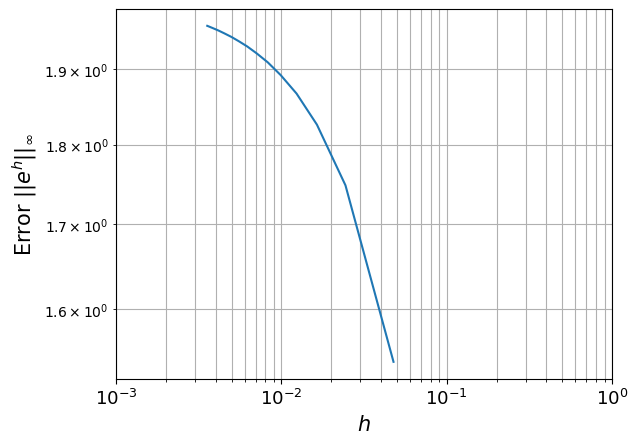

In [45]:
LABELSIZE = 15

fig, ax = plt.subplots()
h_values, errors = convergence(np.arange(20, 300, step=20))
ax.loglog(h_values, errors)
ax.grid(visible=True, which="both")
ax.set_xlabel("$h$", size=LABELSIZE)
ax.set_ylabel(r"Error $||e^h||_\infty$", size=LABELSIZE)
ax.set_xticks(np.logspace(-3, 0, num=4))
ax.tick_params(axis="both", which="major", labelsize=LABELSIZE-2)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [7]:
xy = np.linspace(0, 1, 11)
X, Y = np.meshgrid(xy, xy, indexing="xy")

print("xy")
printmatrix(xy, fp=1, bs=4)
print("X =")
printmatrix(X, fp=1, bs=4)
print("Y = ")
printmatrix(Y, fp=1, bs=4)

xy
[ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
X =
[[ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]]
Y = 
[[ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
 [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
 [ 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4]
 [